# PowerBI

In this notebook we loop through several basins of interest and calculate the SPI-N for the last 12 months and plot into one table. 

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import logging
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.animation import FuncAnimation

import xarray as xr
import geopandas as gpd

from mergedownloader.file_downloader import FileDownloader, ConnectionType
from mergedownloader.downloader import Downloader
from mergedownloader.inpeparser import *
from mergedownloader.utils import DateProcessor, DateFrequency

In [8]:
InpeTypes._member_names_

['DAILY_RAIN',
 'MONTHLY_ACCUM_YEARLY',
 'DAILY_AVERAGE',
 'MONTHLY_ACCUM',
 'MONTHLY_ACCUM_MANUAL',
 'YEARLY_ACCUM',
 'HOURLY_WRF',
 'MONTHLY_AVG_N',
 'MONTHLY_STD_N',
 'MONTHLY_SP1',
 'MONTHLY_SPI']

In [10]:
InpeTypes['DAILY_RAIN']

<InpeTypes.DAILY_RAIN: 1>

In [3]:
fd = FileDownloader(INPE_SERVER, connection_type=ConnectionType.HTTP)

Using wget through HTTP on: ftp.cptec.inpe.br


In [4]:
downloader = Downloader(
    file_downloader=fd,
    parsers=InpeParsers,
    local_folder='/workspaces/reports_folder/downloads2/',
    log_level=logging.DEBUG
)

In [5]:
InpeParsers

{<InpeTypes.DAILY_RAIN: 1>: Instance of DailyParser,
 <InpeTypes.MONTHLY_ACCUM_YEARLY: 2>: Instance of MonthlyAccumYearlyParser,
 <InpeTypes.DAILY_AVERAGE: 3>: Instance of DailyAverageParser,
 <InpeTypes.MONTHLY_ACCUM: 4>: Instance of MonthlyAccumParser,
 <InpeTypes.MONTHLY_ACCUM_MANUAL: 5>: Instance of MonthlyAccumManual,
 <InpeTypes.YEARLY_ACCUM: 6>: Instance of YearAccumulatedParser,
 <InpeTypes.MONTHLY_SP1: 10>: Instance of SPI1Processor,
 <InpeTypes.MONTHLY_AVG_N: 8>: Instance of MonthlyAvgNParser,
 <InpeTypes.MONTHLY_STD_N: 9>: Instance of MonthlyStdNParser,
 <InpeTypes.MONTHLY_SPI: 11>: Instance of SPIProcessor}

## Loading Layers

<Axes: >

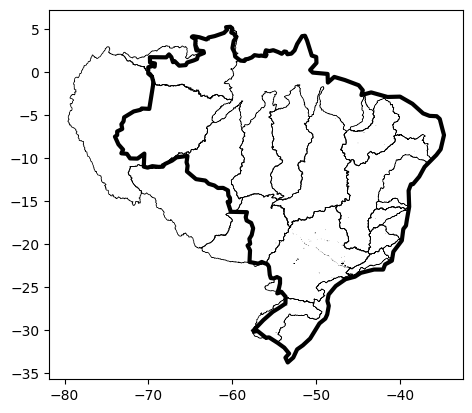

In [6]:
countries = gpd.read_file('https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_admin_0_countries.geojson')
br = countries.query("adm0_a3 == 'BRA'")
basins = gpd.read_file('/workspaces/bases/bacias de interesse SOE/bacias_interesse_ANA.shp')
ax = br.plot(facecolor='none', linewidth=3)
basins.plot(ax=ax, facecolor='none', linewidth=0.5)

In [8]:
basin_names = {
    -1: 'Brasil',
    12: 'Madeira',
    1: 'Doce',
    3: 'Paraguai',
    4: 'Parana',
    6: 'Parnaíba',
    7: 'São Francisco',
    8: 'Solimões',
    9: 'Tapajós', 
    10: 'Uruguai',
    13: 'Paraíba do Sul',
    14: 'Tocantins',
    15: 'Xingú',
}

## Loop through the basins

In [19]:
import pandas as pd
result = pd.DataFrame()

for basin_id in basin_names:
    spi_cube = downloader.create_cube('2023-08', '2024-08', datatype=InpeTypes.MONTHLY_SPI, n=12)

    # if id is -1, then select the whole country
    if basin_id == -1:
        basin = br
    else:
        basin = basins.loc[[basin_id]]

    # clip the basin of interest
    spi_basin = spi_cube.rio.clip(basin['geometry'])

    series = spi_basin.mean(dim=['latitude', 'longitude']).to_series()

    result[basin_names[basin_id]] = series


In [23]:
result.index = result.index.strftime('%Y-%m')

In [25]:
result = result.T

In [26]:
result

time,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08
Brasil,-0.219978,-0.255718,-0.315908,-0.518853,-0.771929,-0.919298,-0.919205,-1.061872,-1.011685,-1.037547,-1.043481,-1.054776,-1.084378
Madeira,-0.375813,-0.450465,-0.682548,-0.638635,-0.822486,-1.035312,-1.021285,-1.312100,-1.439931,-1.582803,-1.672450,-1.649515,-1.696411
Doce,-0.313409,-0.361116,-0.398075,-1.025364,-1.527573,-1.810816,-1.502507,-1.254406,-1.469676,-1.476606,-1.472709,-1.532594,-1.769030
Paraguai,0.115225,0.018873,-0.152391,-0.013874,-0.080087,-0.525895,-0.831101,-1.263097,-1.317192,-1.473766,-1.603651,-1.586445,-1.624160
Parana,-0.079963,-0.326847,-0.179402,-0.003403,-0.343669,-0.759385,-1.117060,-1.184781,-1.312209,-1.329609,-1.476910,-1.455200,-1.538005
Parnaíba,0.009058,-0.049951,-0.162205,-0.627620,-0.801984,-0.538855,-0.071139,-0.299266,0.121105,-0.062038,-0.062009,-0.047509,-0.077908
São Francisco,-0.229224,-0.248195,-0.222352,-0.954672,-1.410671,-1.257124,-0.622272,-0.632908,-0.488968,-0.545648,-0.560224,-0.550852,-0.610301
Solimões,-0.711715,-0.720707,-0.887734,-0.868763,-0.732227,-1.031325,-1.123434,-1.421143,-1.570878,-1.648297,-1.686096,-1.746405,-1.798478
Tapajós,-0.315955,-0.321524,-0.516852,-0.595289,-0.966218,-1.113580,-1.115013,-1.370573,-1.301163,-1.311706,-1.358533,-1.363332,-1.419103
Uruguai,-1.346392,-0.874826,-0.430390,0.197977,0.500627,0.746255,0.797845,0.971887,1.401555,1.572071,1.672045,1.535919,1.590374


In [33]:
styled_result = result.style.background_gradient(cmap='bwr_r', vmin=-4, vmax=4)

In [34]:
styled_result

time,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08
Brasil,-0.219978,-0.255718,-0.315908,-0.518853,-0.771929,-0.919298,-0.919205,-1.061872,-1.011685,-1.037547,-1.043481,-1.054776,-1.084378
Madeira,-0.375813,-0.450465,-0.682548,-0.638635,-0.822486,-1.035312,-1.021285,-1.312100,-1.439931,-1.582803,-1.672450,-1.649515,-1.696411
Doce,-0.313409,-0.361116,-0.398075,-1.025364,-1.527573,-1.810816,-1.502507,-1.254406,-1.469676,-1.476606,-1.472709,-1.532594,-1.769030
Paraguai,0.115225,0.018873,-0.152391,-0.013874,-0.080087,-0.525895,-0.831101,-1.263097,-1.317192,-1.473766,-1.603651,-1.586445,-1.624160
Parana,-0.079963,-0.326847,-0.179402,-0.003403,-0.343669,-0.759385,-1.117060,-1.184781,-1.312209,-1.329609,-1.476910,-1.455200,-1.538005
Parnaíba,0.009058,-0.049951,-0.162205,-0.627620,-0.801984,-0.538855,-0.071139,-0.299266,0.121105,-0.062038,-0.062009,-0.047509,-0.077908
São Francisco,-0.229224,-0.248195,-0.222352,-0.954672,-1.410671,-1.257124,-0.622272,-0.632908,-0.488968,-0.545648,-0.560224,-0.550852,-0.610301
Solimões,-0.711715,-0.720707,-0.887734,-0.868763,-0.732227,-1.031325,-1.123434,-1.421143,-1.570878,-1.648297,-1.686096,-1.746405,-1.798478
Tapajós,-0.315955,-0.321524,-0.516852,-0.595289,-0.966218,-1.113580,-1.115013,-1.370573,-1.301163,-1.311706,-1.358533,-1.363332,-1.419103
Uruguai,-1.346392,-0.874826,-0.430390,0.197977,0.500627,0.746255,0.797845,0.971887,1.401555,1.572071,1.672045,1.535919,1.590374


In [28]:
import pandas as pd
import numpy as np

# Sample DataFrame
data = {'A': [10, 20, -30, 40, -50],
        'B': [5, -15, 25, -35, 45],
        'column_of_interest': [1, -2, 3, -4, 5]}

df = pd.DataFrame(data)

# Apply continuous colormap to the entire DataFrame based on 'column_of_interest'
styled_df = df.style.background_gradient(cmap='bwr_r', subset=['column_of_interest'])

# Display the styled DataFrame
styled_df


,A,B,column_of_interest
0,10,5,1
1,20,-15,-2
2,-30,25,3
3,40,-35,-4
4,-50,45,5
